<a href="https://colab.research.google.com/github/yesong98/Going-Deeper-CV-_BS2/blob/main/GD02_%EC%97%86%EB%8B%A4%EB%A9%B4_%EC%96%B4%EB%96%BB%EA%B2%8C_%EB%90%A0%EA%B9%8C%3F_(ResNet_Ablation_Study)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet Ablation Study
<루브릭>
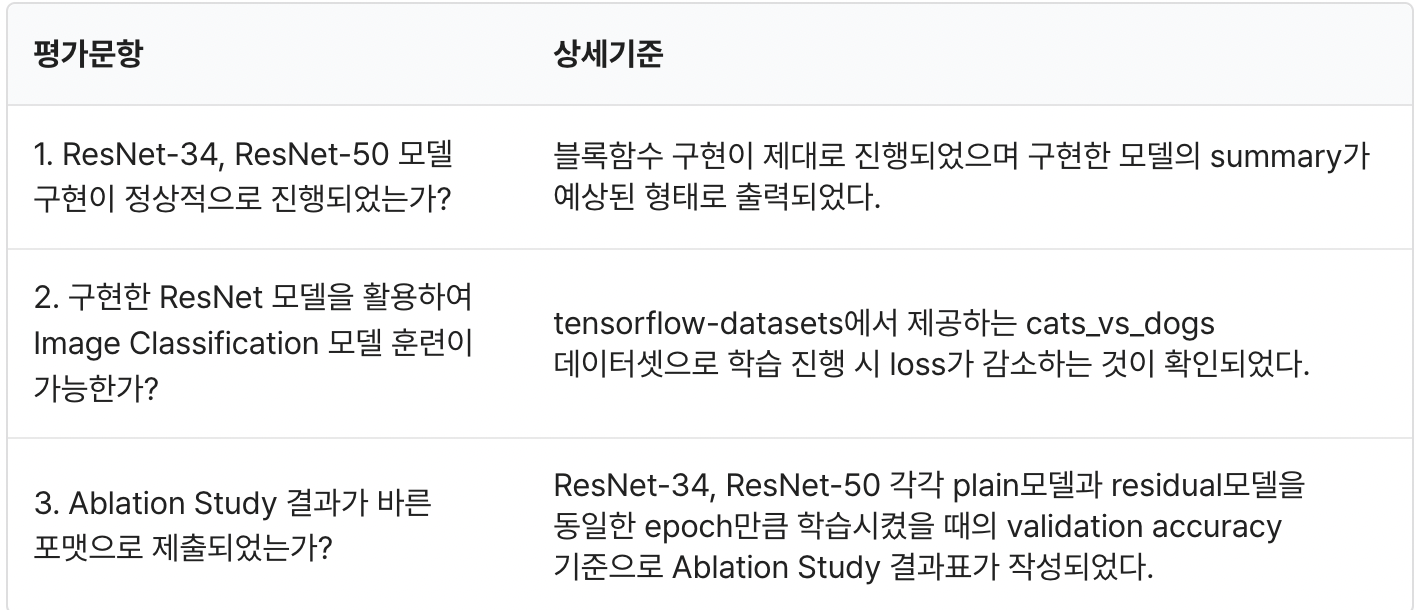

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tqdm.notebook import tqdm

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#pip install -q tfds-nightly tensorflow matplotlib

#1) ResNet 기본 블록 구성하기

### Conv block

- `filters` - [Integer] convolution filter의 수이다. 몇개을 쓸 것인가를 나타낸다. 즉, ootput feature의 채널의 나타낸다.,
- `kernel_size` - [integer, tuple, list] convolution filter를 3x3으로 할지 5x5로 할지 정하는 것이다. 즉 3만 써도 되고 튜플 형태로 (3,3)을 써도 되고 [3, 3]으로 써도 된다.
- `strides` - [kernel_size와 동일] 몇칸을 움직일 것인가
- `paddin` - valid를 써도 되고 same을 써도된다.

In [4]:
def conv_batch(layer, channel , kernel_size , padding='same', strides=1, activation='relu', name='0'):
    x = keras.layers.Conv2D(filters=64,
                            kernel_size=(3,3),
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
    
    return x

## Residual block
### **입력 코드**
- `is_50` : resnet 50을 사용할지 안할지를 정하는 bool 변수(True = ResNet_50, False = ResNet_34 ).  
- `plain` : skip connection을 사용할지 안할지를 정하는 bool 변수이다.  
- `input_layer` : 블럭 앞에 존재하는 입력층을 전달  
- `num_cnn` : 블럭 안에 Conv layer 수  
- 그 외에 channel 수와 몇번째 블럭인지 나타내는 `block_num `   


 


In [5]:
# function for building ResNet Block

def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=0,
                    is_50=False,
                    CHECK_CHANNEL=64,
                    plain=False,
                   ):
#     print(f'입력받은 shape : {input_layer.shape}')

    flag = CHECK_CHANNEL == channel
    bn = 1
    # 입력 레이어
    x = input_layer
    
    # 들어오는 input을 init_identity에 저장시켜 놓는다.
    # 이전 블럭에서 들어오는 정보는 init_identity에서 저장
    init_identity=x

    if not is_50:
        # CNN 레이어
        # 블럭 내부 구성
        for cnn_num in range(num_cnn):
            
            # 블럭의 첫번째 conv층 쌓기
            # 채널이 바뀌면서 이미지의 가로세로 길이가 반으로 줄어야 한다.
            # 채널.......으로 분기문을 주면...
            # 블럭안에서 Shortcut Connection으로 사용할 identity는 여기서 저장
            identity = x
            
            # flag가 False이면 새로운 Conv Block 쌓는다.
            # 그러므로 strides=(2,2)를 사용해서 입력이미지의 사이즈를 줄인다.
            if flag :
                # 첫번째 Conv
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)    
                
            else :
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn += 1
            x = keras.layers.Activation('relu')(x)
            
            ######
            # 두번째 conv 층 (블럭의 conv 마지막 레이어)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2'
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn += 1
            x = keras.layers.Activation('relu')(x)
            
            ###########################
            
            # plain을 True로 주면 아래 shortcut connection을 만들지 않게된다.
            if not plain :
                
                # identity block
                # 채널이 바뀔 때 => identity block에서 strides를 2로 주면서
                # 그때 identity의 가로세로 사이즈를 줄여야한다
                # 맨 처음 입력이 될때는 어떻게 할 것인가? => 기존에 default 값을 64로 주어서 Flag를 True로 유지
                if flag :
                    init_identity = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                else :
                    init_identity = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=(2,2),
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                init_identity = keras.layers.BatchNormalization(
                        name=f'stage{block_num+2}_{cnn_num+1}_bn4'
                )(init_identity)

                flag=True

                # AD
                if cnn_num == 0:
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, init_identity])
                    x = keras.layers.Activation('relu')(x)
                else :
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, identity])
                    x = keras.layers.Activation('relu')(x)
#################################################################### 
    # is_50 = Flase
    else:

        for cnn_num in range(num_cnn):
            
            # 블럭의 첫번째 conv층 쌓기
            identity = x
            
            if flag :
                 x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)    
                
            else :
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                

            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
            
            ######
            # 두번째 conv 층 (블럭의 conv 마지막 레이어)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2',
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
            
            ### 3번째 Conv (앞에 채널의 4배)
            x = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv3'
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
            
            ###########################
            
            # identity block
            # 채널이 바뀔 때 => identity block에서 strides를 2로 주면서
            # 그때 identity의 가로세로 사이즈를 줄여야한다
            # 맨 처음 입력이 될때는 어떻게 할 것인가? => 기존에 default 값을 64로 주면 될듯
            
            if not plain :
                
                if flag :
                    init_identity = keras.layers.Conv2D(
                        filters=channel*4,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                else :
                    init_identity = keras.layers.Conv2D(
                        filters=channel*4,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=(2,2),
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                init_identity = keras.layers.BatchNormalization(
                    name=f'stage{block_num+2}_{cnn_num+1}_bn4'
                )(init_identity)

                flag=True


                # AD
                # 블럭의 첫번째 shortcut connection에서는 init_identity를 사용
                # 이후 shortcut connection에서는 블럭 내에서 생기는 identity를 사용
                if cnn_num == 0:
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, init_identity])
                    x = keras.layers.Activation('relu')(x)
                else :
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, identity])
                    x = keras.layers.Activation('relu')(x)
#################################################################### 

    return x, CHECK_CHANNEL

## ResNet Bulid

In [6]:
# ResNet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3, 4, 6, 3],
              channel_list=[64,128,256,512],
              num_classes=10,
                is_50=False,
                plain=False,):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape, name="input_layer")  # input layer를 만들어둡니다.
    output = input_layer # 뒤에서 사용하는 인자와 통일해주기 위해서 'output'이라고 한다
    
    output = keras.layers.Conv2D(
        filters=channel_list[0],
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(
        pool_size=(2,2), 
        strides=2,
        name='stage2_0_maxpooling'
    )(output)
    
    cc = 64
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output, cc = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50=is_50,
            CHECK_CHANNEL=cc,
            plain=plain
        )
        
    output = keras.layers.AveragePooling2D(pool_size=(1,1), name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='fc1000')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

#2) ResNet-34, ResNet-50 Complete Model

## ResNet-34

In [7]:
# 기본값을 그대로 사용해서 ResNet-34모델을 building한다.
resnet_34 = build_resnet()

resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_layer[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

## ResNet-50


In [8]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
resnet_50 = build_resnet(
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64,128,256,512],
    is_50=True, 
)

resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   9472        ['input_layer[0][0]']            
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 16, 16, 64)  256         ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_49 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_1[0][

#3) 일반 네트워크(plain network) 만들기
### (1)블록코드 수정

In [9]:
# function for building ResNet Block
# Residual Block 제거
def build_plain_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=0,
                    is_50=False,
                    CHECK_CHANNEL=64,
#                   plain=False,
                   ):
#     print(f'입력받은 shape : {input_layer.shape}')

    flag = CHECK_CHANNEL == channel
    bn = 1
    # 입력 레이어
    x = input_layer
    
    # 들어오는 input을 init_identity에 저장시켜 놓는다.
    # 이전 블럭에서 들어오는 정보는 init_identity에서 저장
    init_identity=x

    if not is_50:
        # CNN 레이어
        # 블럭 내부 구성
        for cnn_num in range(num_cnn):
            
            # 블럭의 첫번째 conv층 쌓기
            # 채널이 바뀌면서 이미지의 가로세로 길이가 반으로 줄어야 한다.
            # 채널.......으로 분기문을 주면...
            # 블럭안에서 Shortcut Connection으로 사용할 identity는 여기서 저장
            identity = x
            
            # flag가 False이면 새로운 Conv Block 쌓는다.
            # 그러므로 strides=(2,2)를 사용해서 입력이미지의 사이즈를 줄인다.
            if flag :
                # 첫번째 Conv
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)    
                
            else :
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn += 1
            x = keras.layers.Activation('relu')(x)
            
            ######
            # 두번째 conv 층 (블럭의 conv 마지막 레이어)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2'
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn += 1
            x = keras.layers.Activation('relu')(x)
 # is_50 = Flase
    else:

        for cnn_num in range(num_cnn):
            
            # 블럭의 첫번째 conv층 쌓기
            identity = x
            
            if flag :
                 x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)    
                
            else :
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                

            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
            
            ######
            # 두번째 conv 층 (블럭의 conv 마지막 레이어)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2',
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
            
            ### 3번째 Conv (앞에 채널의 4배)
            x = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv3'
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
    return x, CHECK_CHANNEL          

###(2)전체 함수코드 수정

In [10]:
# ResNet 모델 자체를 생성하는 함수입니다.
def build_plain(input_shape=(32,32,3),
                num_cnn_list=[3, 4, 6, 3],
                channel_list=[64,128,256,512],
                num_classes=10,
                is_50=False,
#               plain=False,
                ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape, name="input_layer")  # input layer를 만들어둡니다.
    output = input_layer # 뒤에서 사용하는 인자와 통일해주기 위해서 'output'이라고 한다
    
    output = keras.layers.Conv2D(
        filters=channel_list[0],
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(
        pool_size=(2,2), 
        strides=2,
        name='stage2_0_maxpooling'
    )(output)
    
    cc = 64
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output, cc = build_plain_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50=is_50,
            CHECK_CHANNEL=cc,
#           plain=plain
        )
        
    output = keras.layers.AveragePooling2D(pool_size=(1,1), name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='fc1000')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [11]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3)
                       )
plain_34.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_2 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_114 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 stage2_0_maxpooling (MaxPoo  (None, 56, 56, 64)       0         
 ling2D)                                                         
                                                                 
 stage2_1_conv1 (Conv2D)     (None, 56, 56, 64)        3692

In [12]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))
plain_50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_3 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_147 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 stage2_0_maxpooling (MaxPoo  (None, 56, 56, 64)       0         
 ling2D)                                                         
                                                                 
 stage2_1_conv1 (Conv2D)     (None, 56, 56, 64)        4160

#4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

###(1)Ablation study
#### Cat vs Dog

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]',
           'train[80%:]',
          ],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete8EE3A9/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [14]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [15]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [16]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224,224)) # resize
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [17]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

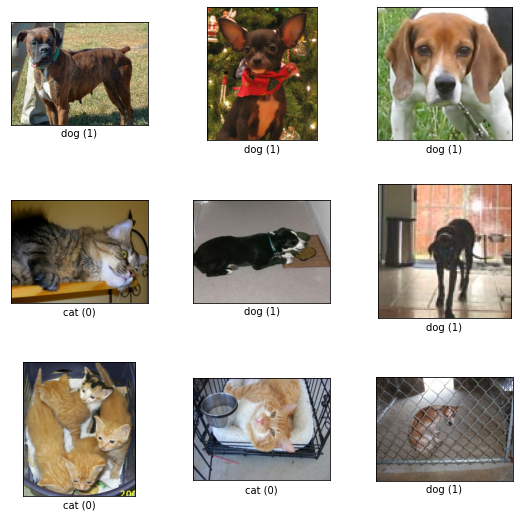

In [18]:
fig = tfds.show_examples(ds_train, ds_info)

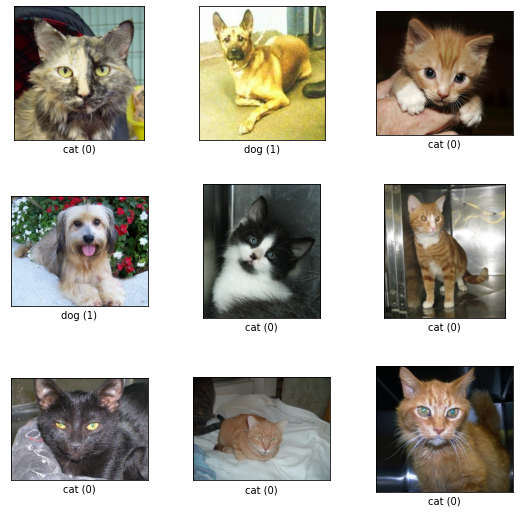

In [19]:
fig = tfds.show_examples(ds_test, ds_info)

### Train
- input_shape를 (224, 224, 3)으로 하여서 위 4가지 모델을 새로 생성 후 학습을 진행

In [23]:
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCH = 10

### ResNet

In [21]:
resnet_34 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=False,
    plain=False
    )

In [22]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
resnet_50 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64,128,256,512],
    num_classes=1,
    is_50=True, 
    plain=False
    )

In [24]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [27]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
#   use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 132s 206ms/step - loss: 1.3263 - accuracy: 0.5799 - val_loss: 1.7858 - val_accuracy: 0.5468
Epoch 2/10
581/581 [==============================] - 121s 208ms/step - loss: 0.8502 - accuracy: 0.6609 - val_loss: 0.6341 - val_accuracy: 0.7067
Epoch 3/10
581/581 [==============================] - 122s 209ms/step - loss: 0.7608 - accuracy: 0.7272 - val_loss: 0.7279 - val_accuracy: 0.6621
Epoch 4/10
581/581 [==============================] - 121s 209ms/step - loss: 0.6648 - accuracy: 0.7724 - val_loss: 2.3394 - val_accuracy: 0.7041
Epoch 5/10
581/581 [==============================] - 122s 210ms/step - loss: 0.5158 - accuracy: 0.8160 - val_loss: 1.0833 - val_accuracy: 0.7265
Epoch 6/10
581/581 [==============================] - 122s 210ms/step - loss: 0.5740 - accuracy: 0.8396 - val_loss: 0.9193 - val_accuracy: 0.7946
Epoch 7/10
581/581 [==============================] - 122s 209ms/step - loss: 0.3882 - accuracy: 0.8856 - val_loss: 0.7375 - val_accura

In [28]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
#   use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 122s 199ms/step - loss: 0.1537 - accuracy: 0.9652 - val_loss: 0.6561 - val_accuracy: 0.8024
Epoch 2/10
581/581 [==============================] - 121s 208ms/step - loss: 0.1116 - accuracy: 0.9681 - val_loss: 1.2596 - val_accuracy: 0.7755
Epoch 3/10
581/581 [==============================] - 122s 209ms/step - loss: 0.0704 - accuracy: 0.9812 - val_loss: 0.8202 - val_accuracy: 0.8045
Epoch 4/10
581/581 [==============================] - 121s 208ms/step - loss: 0.0511 - accuracy: 0.9852 - val_loss: 0.8993 - val_accuracy: 0.8030
Epoch 5/10
581/581 [==============================] - 122s 210ms/step - loss: 0.0440 - accuracy: 0.9875 - val_loss: 1.1709 - val_accuracy: 0.8120
Epoch 6/10
581/581 [==============================] - 122s 210ms/step - loss: 0.0468 - accuracy: 0.9885 - val_loss: 1.3034 - val_accuracy: 0.8037
Epoch 7/10
581/581 [==============================] - 122s 209ms/step - loss: 0.0189 - accuracy: 0.9947 - val_loss: 1.3862 -

### Plain

In [29]:
plain_34 = build_plain(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=False,
    )

In [30]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 87s 129ms/step - loss: 0.8632 - accuracy: 0.5023 - val_loss: 0.6987 - val_accuracy: 0.5071
Epoch 2/10
581/581 [==============================] - 73s 126ms/step - loss: 0.6961 - accuracy: 0.5047 - val_loss: 0.6955 - val_accuracy: 0.5093
Epoch 3/10
581/581 [==============================] - 74s 127ms/step - loss: 0.6924 - accuracy: 0.5187 - val_loss: 0.6904 - val_accuracy: 0.5472
Epoch 4/10
581/581 [==============================] - 74s 128ms/step - loss: 0.6956 - accuracy: 0.5013 - val_loss: 0.6936 - val_accuracy: 0.4840
Epoch 5/10
581/581 [==============================] - 75s 129ms/step - loss: 0.6888 - accuracy: 0.5427 - val_loss: 0.6926 - val_accuracy: 0.5457
Epoch 6/10
581/581 [==============================] - 75s 129ms/step - loss: 0.6862 - accuracy: 0.5460 - val_loss: 0.6845 - val_accuracy: 0.5784
Epoch 7/10
581/581 [==============================] - 74s 128ms/step - loss: 0.6834 - accuracy: 0.5547 - val_loss: 0.6887 - val_ac

In [32]:
plain_50 = build_plain(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=True
    )

In [33]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 107s 161ms/step - loss: 1.3090 - accuracy: 0.4936 - val_loss: 0.6980 - val_accuracy: 0.5065
Epoch 2/10
581/581 [==============================] - 93s 160ms/step - loss: 0.8166 - accuracy: 0.5035 - val_loss: 2.5534 - val_accuracy: 0.4941
Epoch 3/10
581/581 [==============================] - 93s 160ms/step - loss: 0.6962 - accuracy: 0.5040 - val_loss: 0.7151 - val_accuracy: 0.5088
Epoch 4/10
581/581 [==============================] - 93s 160ms/step - loss: 0.6950 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5084
Epoch 5/10
581/581 [==============================] - 93s 160ms/step - loss: 0.6952 - accuracy: 0.5026 - val_loss: 0.6984 - val_accuracy: 0.5054
Epoch 6/10
581/581 [==============================] - 93s 160ms/step - loss: 0.6955 - accuracy: 0.4981 - val_loss: 0.6936 - val_accuracy: 0.4894
Epoch 7/10
581/581 [==============================] - 93s 160ms/step - loss: 0.6942 - accuracy: 0.5018 - val_loss: 0.6943 - val_a

###(2)시각화

###  Residual vs Plain 의 loss 비교

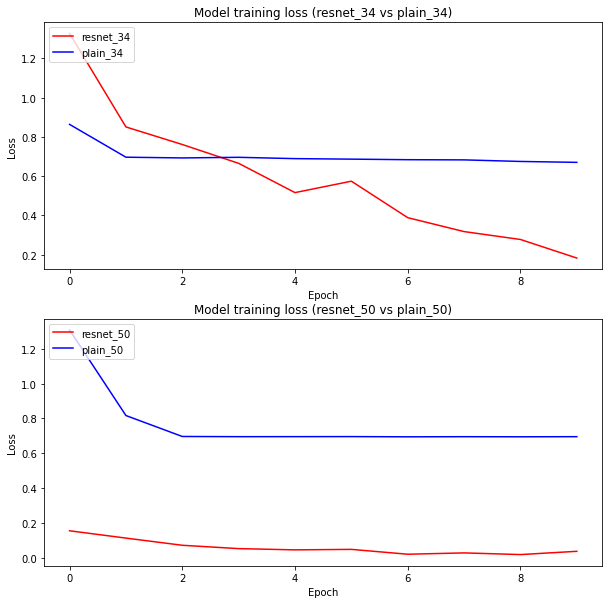

In [43]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss (resnet_34 vs plain_34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss (resnet_50 vs plain_50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.show()

#### (1)resnet-34 vs Plain-34
loss값을 비교해보았을 때 resnet의 그래프가 안정적으로 그려졌고 plain의 경우 loss값이 더이상 떨어지지 않았다.

#### (2)resnet-50 vs Plain-50
plain에 비해 resnet의 loss값이 현저히 낮은것을 볼 수 있다.

### Residual vs Plain 의 accuracy 비교

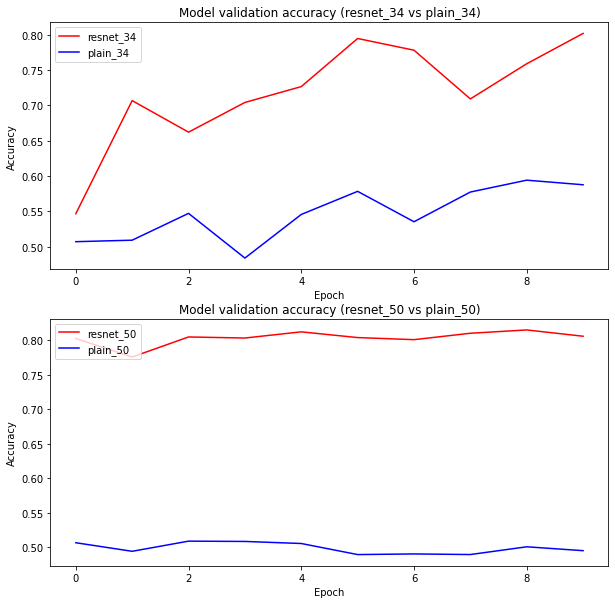

In [42]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy (resnet_34 vs plain_34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy (resnet_50 vs plain_50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

#### (1)resnet-34 vs Plain-34
accuracy를 비교해 보았을 때 resnet의 정확도가 더 높은 것을 확인할 수 있다

#### (2)resnet-50 vs Plain-50
accuracy를 비교해 보았을 때 resnet의 정확도가 더 높은 것을 확인할 수 있다. 그런데 위의 34layers 의 그래프보다 50layers 에서 더 많이 accuracy값의 차이가 나는 것을 볼 수 있다.
(오..이게 shortcut 유무 차이인건가)

### ResNet-34 vs ResNet-50(Validation Accurcay)

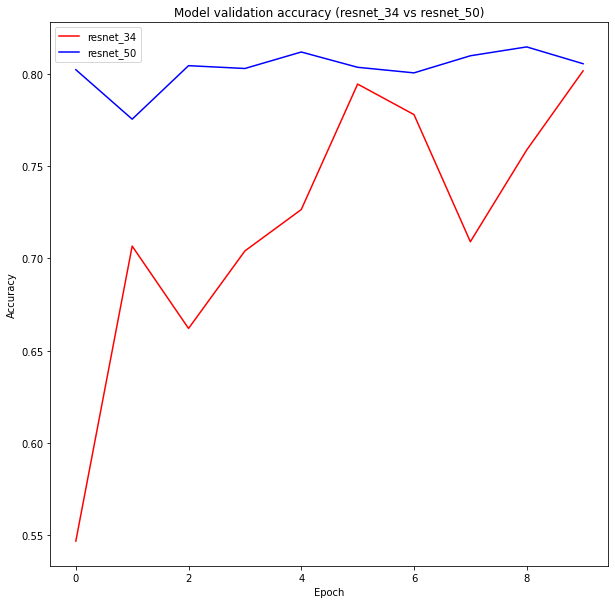

In [41]:
plt.figure(figsize=(10, 10))
plt.subplot()
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy (resnet_34 vs resnet_50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()


- 논문에서 이야기 한것과 같이 resnet-34 와 resnet-50의 val-acc를 비교해봤을때 resnet-50이 더 높은 accuracy값을 가지는 것을 알 수 있다. 
- 이전에 학습을 시켰을 때 accuracy값이 resnet-50이 낮게나와 확인해 보니, conv layer에서 fillter와 kenel size의 값을 지정해주지 않고 학습을 시킨것이다.

# ✏️회고
1)전체적인 결과
단순히 네트워크 깊이만 깊어지만 무조건 성능이 좋아질까?라는 의문으로 시작된 Resnet논문으로 Residual Block이 존재한다.  
기존(Plain)의 망과 차이가 있다면 입력값을 출력값에 더해줄 수 있도록 지름길(shortcut)을 하나 만들어준 것 뿐이다.
그래서 Plain과 Residual을 비교했을 때는 Redsidual의 그래프가 더 안정적인 것을 알 수 있다.

2) Plain model, Residual model 의 차이
- 동일한 연산을 하고 나서 Input인 x를 더하는 것(Residual Block)과 더하지 않는 것(Plane layer)의 차이이다.
- 단순하게 Input x를 더하는 것만으로 layer는 Direct로 학습하는 것 대신에, Skip Connection을 통해 각각의 layer(Block)들이 작은 정보만을 추가적으로 학습하도록 한다.  
(= 각각의 layer가 배워야 할 정보량을 축소) 
- 즉 기존에 학습된 x를 추가함으로써 x만큼을 제외한 나머지 부분(F(X))만을 학습하면 되므로 학습량이 상대적으로 줄어드는 효과가 있다.

3) Resnet-34, Resnet-50 비교
-  Resnet-50부터는 1x1, 3x3, 1x1으로 아래 그림처럼 구성이 된다
- dimension을 줄이기 위한 목적이며, 이렇게 dimension을 줄인 뒤 3x3 convolution을 수행 한 후, 마지막 1x1 convolution은 다시 dimension을 확대시키는 역할을 한다. 
- 결과적으로 3x3 convolution 2개를 곧바로 연결시킨 구조에 비해 연산량을 절감시킬 수 있게 된다.

## Reference
- https://hwanny-yy.tistory.com/12
- https://github.com/PEBpung/Aiffel/blob/master/Project/Going%20Deeper/G2.%20ResNet%20Ablation%20Study.ipynb
- https://velog.io/@lighthouse97/ResNet%EC%9D%98-%EC%9D%B4%ED%95%B4